0. Создание файла с входными данными

In [8]:
import json
geojson_data = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {"name": "Зона застройки"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[[37.6173, 55.7558], [37.6179, 55.7565], [37.6185, 55.7559], [37.6173, 55.7558]]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Лесная зона", "restriction": "no_build"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[[37.6180, 55.7560], [37.6185, 55.7565], [37.6190, 55.7560], [37.6180, 55.7560]]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Дорога", "restriction": "no_build"},
      "geometry": {
        "type": "LineString",
        "coordinates": [[37.6175, 55.7555], [37.6185, 55.7555]]
      }
    }
  ]
}

# Сохранение данных в файл GeoJSON
with open('input.geojson', 'w') as f:
    json.dump(geojson_data, f)

print("Данные сохранены в файл input.geojson")


Данные сохранены в файл input.geojson


1. Импорт необходимых библиотек и загрузка данных

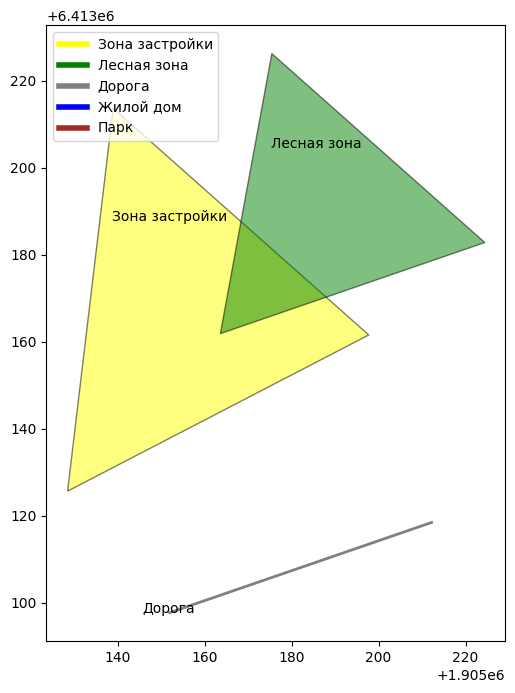

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import shape, Polygon, LineString, Point
from shapely.ops import transform
import networkx as nx

# Загрузка данных
with open('input.geojson') as f:
    geo_data = json.load(f)

# Преобразование GeoJSON в GeoDataFrame с извлечением свойств
features = geo_data["features"]
for feature in features:
    feature['geometry'] = shape(feature['geometry'])

gdf = gpd.GeoDataFrame(features)
gdf['name'] = gdf['properties'].apply(lambda x: x['name'])
gdf['restriction'] = gdf['properties'].apply(lambda x: x.get('restriction', None))

# Преобразование координат
wgs84 = CRS("EPSG:4326")  # Координаты в долготе и широте
utm = CRS("EPSG:32633")   # Координаты в метрах

transformer = Transformer.from_crs(wgs84, utm, always_xy=True)
gdf['geometry'] = gdf['geometry'].apply(lambda geom: transform(transformer.transform, geom))
gdf.set_crs(utm.to_string(), inplace=True)  # Устанавливаем CRS для GeoDataFrame

# Назначение цветов для разных типов зон
color_map = {
    'Зона застройки': 'yellow',
    'Лесная зона': 'green',
    'Дорога': 'gray',
    'Жилой дом': 'blue',
    'Парк': 'brown'
}

# Отрисовка графика с цветами
fig, ax = plt.subplots(figsize=(10, 8))  # Увеличиваем размер графика
for _, row in gdf.iterrows():
    geom_type = row['geometry'].geom_type
    color = color_map.get(row['name'], 'black')
    if geom_type == 'Polygon':
        gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
    elif geom_type == 'LineString':
        gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, linewidth=2)

# Добавление подписи для каждого участка
for _, row in gdf.iterrows():
    coords = row['geometry'].representative_point().coords[0]
    plt.text(coords[0], coords[1], row['name'], horizontalalignment='center', fontsize=10)

# Легенда
legend_labels = [plt.Line2D([0], [0], color=color_map[name], lw=4) for name in color_map]
legend_names = list(color_map.keys())
plt.legend(legend_labels, legend_names)

plt.show()

2. Определение функций

In [10]:
# Функция проверки, можно ли строить в заданной точке
def can_build_at_point(polygon, gdf):
    for _, row in gdf.iterrows():
        if row['geometry'].intersects(polygon) and row['restriction'] == 'no_build':
            return False
    return True

# Функция для размещения нескольких домов с ограничением по расстоянию между строениями
def place_multiple_houses(gdf, build_zone, house_size, max_density):
    buildings = []
    build_area = build_zone.iloc[0]['geometry'].area
    max_build_area = build_area * max_density

    current_build_area = 0
    minx, miny, maxx, maxy = build_zone.total_bounds

    for x in range(int(minx), int(maxx - house_size), house_size + min_distance):
        for y in range(int(miny), int(maxy - house_size), house_size + min_distance):
            house_polygon = Polygon([(x, y), (x + house_size, y), (x + house_size, y + house_size), (x, y + house_size)])
            if build_zone.iloc[0]['geometry'].contains(house_polygon) and can_build_at_point(house_polygon, gdf):
                buildings.append(house_polygon)
                current_build_area += house_polygon.area
                if current_build_area >= max_build_area:
                    break

    return buildings

# Функция для размещения парка без учета существования лесной зоны и ограничения по расстоянию
def place_park(gdf, build_zone, park_size):
    park = None
    build_polygon = build_zone.iloc[0]['geometry']

    minx, miny, maxx, maxy = build_polygon.bounds
    for x in range(int(minx), int(maxx - park_size), park_size):
        for y in range(int(miny), int(maxy - park_size), park_size):
            park_polygon = Polygon([(x, y), (x + park_size, y), (x + park_size, y + park_size), (x, y + park_size)])
            if build_polygon.contains(park_polygon) and can_build_at_point(park_polygon, gdf):
                if not any(building.intersects(park_polygon) for building in gdf[gdf['name'] == 'Жилой дом']['geometry']):
                    park = park_polygon
                    break

    return park

# Прокладка дорог
def connect_houses_with_roads(gdf):
    roads = []
    road_network = nx.Graph()

    existing_roads = gdf[gdf['name'] == 'Дорога']['geometry']
    houses = gdf[gdf['name'] == 'Жилой дом']['geometry']

    # Создание графа дорог
    for road in existing_roads:
        for start, end in zip(road.coords[:-1], road.coords[1:]):
            road_network.add_edge(start, end, weight=Point(start).distance(Point(end)))

    def get_nearest_point(exterior, point):
        nearest_point = exterior.coords[0]
        min_distance = point.distance(Point(nearest_point))
        for coord in exterior.coords:
            dist = point.distance(Point(coord))
            if dist < min_distance:
                nearest_point = coord
                min_distance = dist
        return nearest_point

    # Подключение домов к существующим дорогам
    for house in houses:
        house_centroid = house.centroid
        nearest_road_node = min(road_network.nodes, key=lambda node: Point(node).distance(house_centroid))

        # Находим ближайшую точку на внешнем контуре дома
        house_exterior = house.exterior
        nearest_point = get_nearest_point(house_exterior, Point(nearest_road_node))

        road_network.add_edge(nearest_road_node, nearest_point, weight=Point(nearest_road_node).distance(Point(nearest_point)))
        roads.append(LineString([nearest_road_node, nearest_point]))

    # Подключение домов друг к другу
    connected_houses = set()
    for house in houses:
        house_exterior = house.exterior
        nearest_point = get_nearest_point(house_exterior, house.centroid)
        connected_houses.add(nearest_point)

        for other_house in houses:
            if house != other_house:
                other_house_exterior = other_house.exterior
                other_nearest_point = get_nearest_point(other_house_exterior, other_house.centroid)
                if nearest_point != other_nearest_point:
                    road_network.add_edge(nearest_point, other_nearest_point, weight=Point(nearest_point).distance(Point(other_nearest_point)))
                    roads.append(LineString([nearest_point, other_nearest_point]))

    return roads


3. Установка ограничений

In [11]:
# Ограничения по плотности застройки
max_density = 0.5  # 50%

# Минимальное расстояние между объектами для домов
min_distance = 10  # метров

4. Проверка возможности застройки в заданной точке, добавление объектов

In [12]:
# Определение зоны застройки
build_zone = gdf[gdf['name'] == 'Зона застройки']

# Размещение нескольких домов
house_size = 10  # размер дома 10 на 10 метров
buildings = place_multiple_houses(gdf, build_zone, house_size, max_density)

# Добавление объектов в GeoDataFrame
buildings_gdf = gpd.GeoDataFrame([{'geometry': building, 'name': 'Жилой дом', 'restriction': None} for building in buildings])
gdf = pd.concat([gdf, buildings_gdf], ignore_index=True)

# Размещение парка
park_size = 9  # размер парка 9 на 9 метров
park = place_park(gdf, build_zone, park_size)

if park is not None:
    park_gdf = gpd.GeoDataFrame([{'geometry': park, 'name': 'Парк', 'restriction': None}])
    gdf = pd.concat([gdf, park_gdf], ignore_index=True)

# Прокладка дорог
roads = connect_houses_with_roads(gdf)

# Добавление дорог в GeoDataFrame
roads_gdf = gpd.GeoDataFrame([{'geometry': road, 'name': 'Дорога', 'restriction': None} for road in roads])
gdf = pd.concat([gdf, roads_gdf], ignore_index=True)


C:\Users\fkara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 33N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
C:\Users\fkara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 33N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
C:\Users\fkara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / 

5. Визуализация итогового проекта размещения объектов

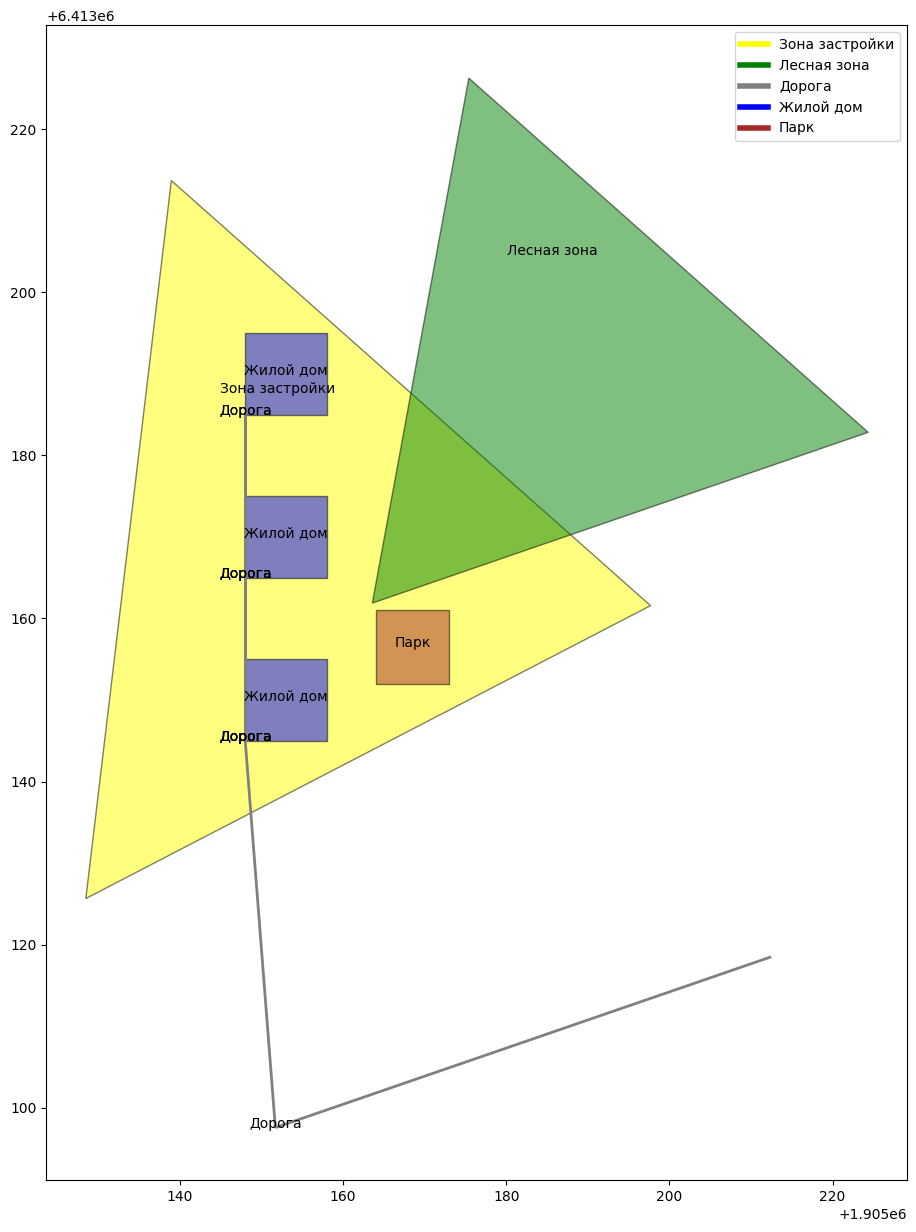

In [13]:
# Отрисовка графика с цветами
fig, ax = plt.subplots(figsize=(20, 15))  # Увеличиваем размер графика
for _, row in gdf.iterrows():
    geom_type = row['geometry'].geom_type
    color = color_map.get(row['name'], 'black')
    if geom_type == 'Polygon':
        gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
    elif geom_type == 'LineString':
        gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, linewidth=2)

# Добавление подписи для каждого участка
for _, row in gdf.iterrows():
    coords = row['geometry'].representative_point().coords[0]
    plt.text(coords[0], coords[1], row['name'], horizontalalignment='center', fontsize=10)

# Легенда
legend_labels = [plt.Line2D([0], [0], color=color_map[name], lw=4) for name in color_map]
legend_names = list(color_map.keys())
plt.legend(legend_labels, legend_names)

# Сохранение GeoDataFrame в файл GeoJSON
gdf.to_file("output.geojson", driver='GeoJSON')

plt.show()

6. Визуализация данных

In [14]:
# Сохранение GeoDataFrame в файл GeoJSON
gdf.to_file("output.geojson", driver='GeoJSON')


7. Проверка итоговых данных

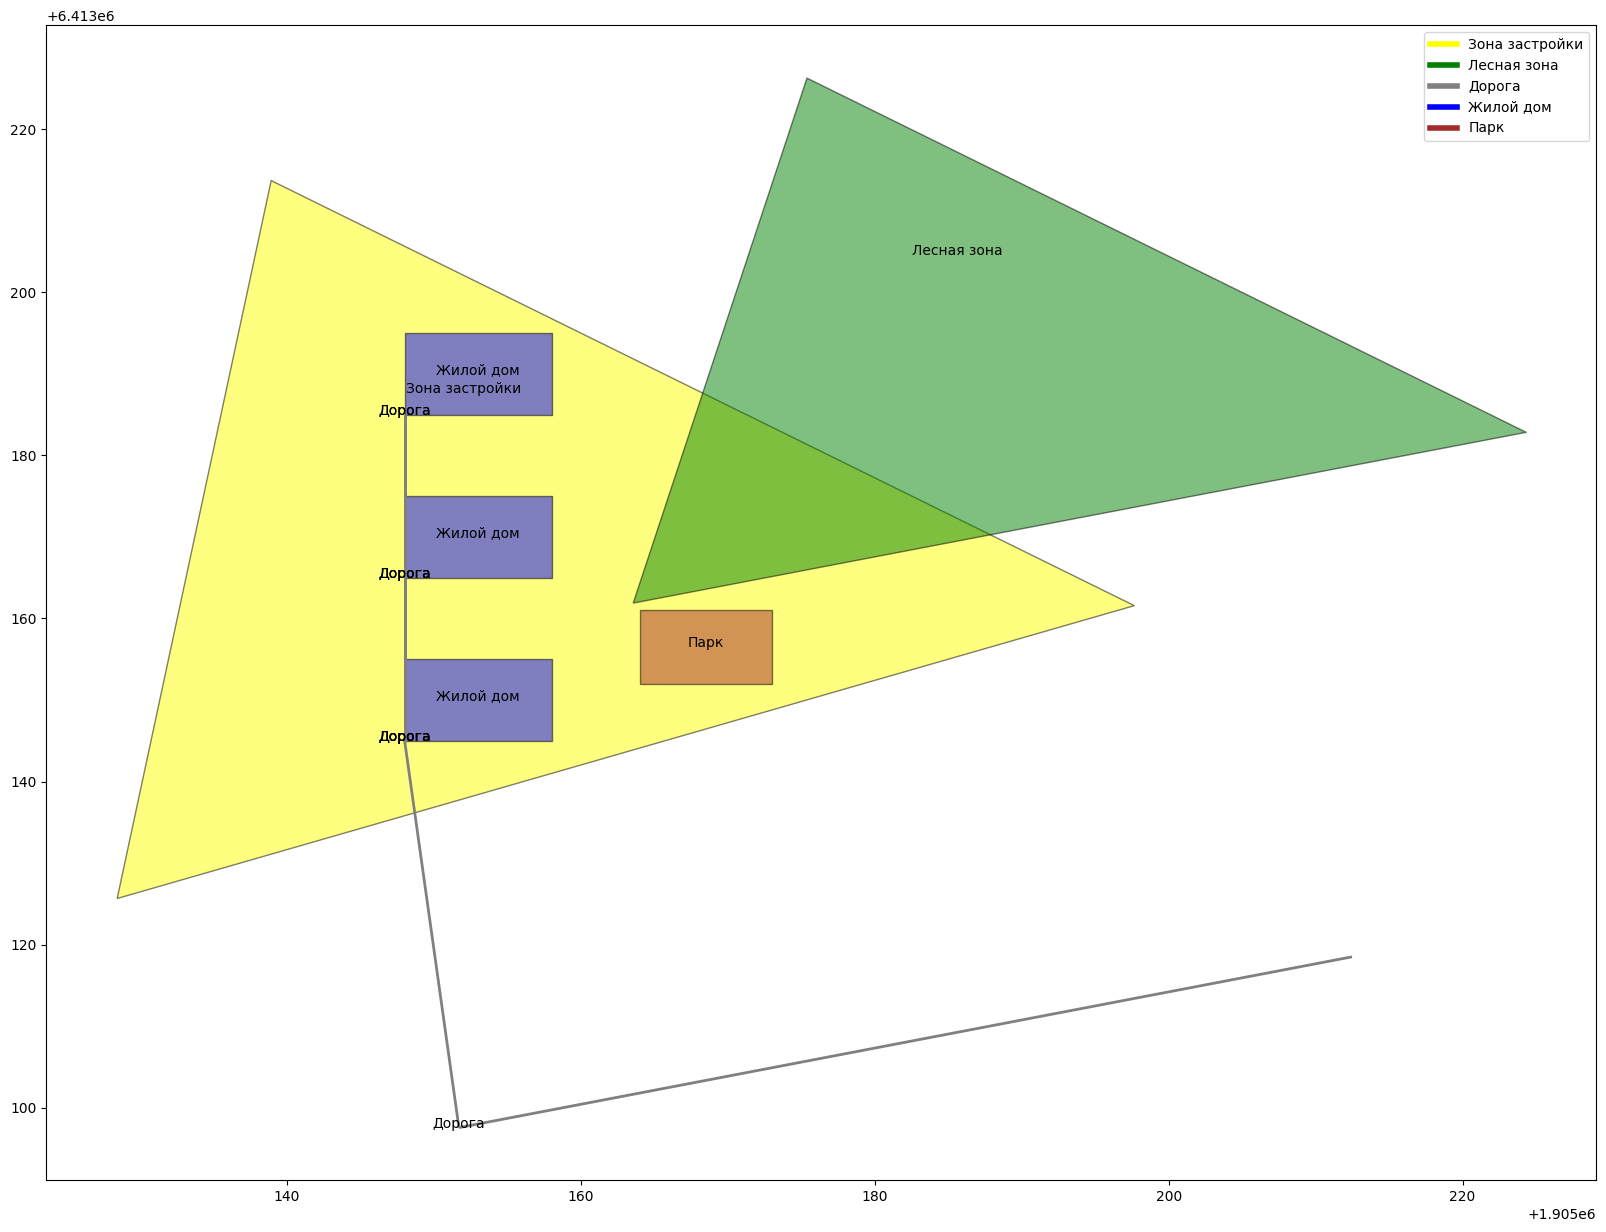

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Назначение цветов для разных типов зон
color_map = {
    'Зона застройки': 'yellow',
    'Лесная зона': 'green',
    'Дорога': 'gray',
    'Жилой дом': 'blue',
    'Парк': 'brown'
}

# Функция визуализации GeoDataFrame
def visualize_gdf(gdf):
    fig, ax = plt.subplots(figsize=(20, 15))  # Увеличиваем размер графика
    for _, row in gdf.iterrows():
        geom_type = row['geometry'].geom_type
        color = color_map.get(row['name'], 'black')
        if geom_type == 'Polygon':
            gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
        elif geom_type == 'LineString':
            gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, linewidth=2)

    for _, row in gdf.iterrows():
        coords = row['geometry'].representative_point().coords[0]
        plt.text(coords[0], coords[1], row['name'], horizontalalignment='center', fontsize=10)

    legend_labels = [plt.Line2D([0], [0], color=color_map[name], lw=4) for name in color_map]
    legend_names = list(color_map.keys())
    plt.legend(legend_labels, legend_names)

    ax.set_aspect('auto')  # Устанавливаем аспект как "auto"
    plt.show()

# Загрузка GeoDataFrame из файла GeoJSON
gdf = gpd.read_file('output.geojson')

# Визуализация GeoDataFrame
visualize_gdf(gdf)
